In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import wb 
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from statsmodels.iolib.summary2 import summary_col

# Download data using pandas_datareader

Download gdp per capita data and electricity power consumption per capita data from world bank.
Then merge them togther.

In [ ]:
wb.search('gdp.*capita')

In [2]:
gdp_data = wb.download(indicator = 'NY.GDP.PCAP.PP.KD', country='all', start=2004, end=2017).dropna()
ele_data = wb.download(indicator = 'EG.USE.ELEC.KH.PC', country='all', start=2004, end=2017).dropna()

In [3]:
data_set = pd.merge(gdp_data, ele_data, on=['country','year'])
data_set.columns = ['gdppc','elepc']
data_set['gdppc'] = data_set['gdppc']/1000
data_set['elepc'] = data_set['elepc']/1000
data_set = data_set.reset_index()
data_set['laggdppc'] = data_set.groupby('country')['gdppc'].shift(1)
data_set['lagelepc'] = data_set.groupby('country')['elepc'].shift(1)

In [ ]:
data_set[data_set['elepc'] >= 30]

In [ ]:
max(data_set['elepc'])

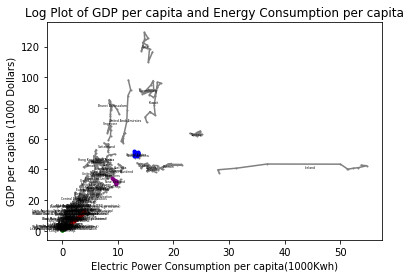

In [4]:
fig, ax = plt.subplots()
for key, grp in data_set.groupby('country'):
    plt.plot(grp.elepc, grp.gdppc, 'o-', markersize=1, color='gray')
    plt.annotate(key,
                data_set.loc[data_set['country']==key,['elepc','gdppc']].mean(),
                horizontalalignment='center',
                verticalalignment='center',
                size=3)
plt.plot(data_set[data_set['country']=='China']['elepc'],
        data_set[data_set['country']=='China']['gdppc'],
        'o-', markersize=3, color='red')
plt.plot(data_set[data_set['country']=='United States']['elepc'],
        data_set[data_set['country']=='United States']['gdppc'],
        'o-', markersize=3, color='blue')
plt.plot(data_set[data_set['country']=='Ethiopia']['elepc'],
        data_set[data_set['country']=='Ethiopia']['gdppc'],
        'o-', markersize=3, color='green')
plt.plot(data_set[data_set['country']=='New Zealand']['elepc'],
        data_set[data_set['country']=='New Zealand']['gdppc'],
        'o-', markersize=3, color='purple')
plt.xlabel("Electric Power Consumption per capita(1000Kwh)")
plt.ylabel("GDP per capita (1000 Dollars)")
plt.title("Log Plot of GDP per capita and Energy Consumption per capita")
fig.savefig('gdpele_country.png', format='png', dpi=300)

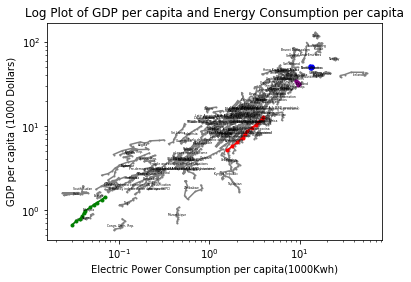

In [5]:
fig, ax = plt.subplots()
ax = plt.axes(xscale='log', yscale='log')
for key, grp in data_set.groupby('country'):
    plt.plot(grp.elepc, grp.gdppc, 'o-', markersize=1, color='gray')
    plt.annotate(key,
                data_set.loc[data_set['country']==key,['elepc','gdppc']].mean(),
                horizontalalignment='center',
                verticalalignment='center',
                size=3)
plt.plot(data_set[data_set['country']=='China']['elepc'],
        data_set[data_set['country']=='China']['gdppc'],
        'o-', markersize=3, color='red')
plt.plot(data_set[data_set['country']=='United States']['elepc'],
        data_set[data_set['country']=='United States']['gdppc'],
        'o-', markersize=3, color='blue')
plt.plot(data_set[data_set['country']=='Ethiopia']['elepc'],
        data_set[data_set['country']=='Ethiopia']['gdppc'],
        'o-', markersize=3, color='green')
plt.plot(data_set[data_set['country']=='New Zealand']['elepc'],
        data_set[data_set['country']=='New Zealand']['gdppc'],
        'o-', markersize=3, color='purple')
plt.xlabel("Electric Power Consumption per capita(1000Kwh)")
plt.ylabel("GDP per capita (1000 Dollars)")
plt.title("Log Plot of GDP per capita and Energy Consumption per capita")
fig.savefig('gdpele_country_log.png', format='png', dpi=300)

# Conduct OLS regression with/without fixed effects.

In [6]:
data_set['elepc'] = np.log(data_set['elepc'])
data_set['gdppc'] = np.log(data_set['gdppc'])
data_set['lagelepc'] = np.log(data_set['lagelepc'])
data_set['laggdppc'] = np.log(data_set['laggdppc'])

KeyError: 'logelepc'

In [ ]:
normal_ols = sm.ols(formula = 'gdppc ~ elepc', data = data_set).fit(cov_type='HC1')
print(normal_ols.summary())

In [ ]:
panel_ols = sm.ols(formula = 'gdppc ~ elepc + C(country) + C(year)', data = data_set).fit(cov_type='HC1')
print(panel_ols.summary())

In [ ]:
panel_ols_lagele = sm.ols(formula = 'gdppc ~ lagelepc + C(country) + C(year)', data = data_set).fit(cov_type='HC1')
print(panel_ols_lagele.summary())

In [ ]:
print(summary_col([normal_ols, panel_ols],stars=True,float_format='%0.2f'))

In [ ]:
def country_reg(cont):
    res = sm.ols(formula = 'gdppc ~ elepc ', data = data_set[data_set['country']==cont]).fit(cov_type='HC1')
    return [cont, res.params['elepc']]
coefs = [country_reg(x) for x in set(data_set['country'])]
coefs = pd.DataFrame(coefs, columns=['country', 'value'])  
    

In [ ]:
coefs[coefs['value']<0]

In [ ]:
mod = sm.quantreg('gdppc ~ elepc ', data_set)
quantiles = np.arange(.05, .96, .1)
def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['elepc']] + \
            res.conf_int().loc['elepc'].tolist()
models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns = ['q', 'a', 'b', 'lb','ub'])

ols = sm.ols('gdppc ~ elepc ', data_set).fit()
ols_ci = ols.conf_int().loc['elepc'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['elepc'],
           lb = ols_ci[0],
           ub = ols_ci[1])
print(models)
print(ols)

In [ ]:
n = models.shape[0]
p1 = plt.plot(models.q, models.b, color='black', label='Quantile Reg.')
p2 = plt.plot(models.q, models.ub, linestyle='dotted', color='black')
p3 = plt.plot(models.q, models.lb, linestyle='dotted', color='black')
p4 = plt.plot(models.q, [ols['b']] * n, color='red', label='OLS')
p5 = plt.plot(models.q, [ols['lb']] * n, linestyle='dotted', color='red')
p6 = plt.plot(models.q, [ols['ub']] * n, linestyle='dotted', color='red')
plt.ylabel(r'$\beta_{Electricity Consumption}$')
plt.xlabel('Quantiles of the conditional electricity consumption distribution')
plt.legend()
plt.show()